In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

In [19]:
%ls

crop_prediction_weights_final_BELOW7LOSS_1_LOSS10.pth
crop_prediction_weights_final_BELOW7LOSS_1_LOSS9.pth
crop_prediction_weights_final_BELOW7LOSS_2_LOSS10.pth
crop_prediction_weights_final_BELOW7LOSS_3_LOSS10.pth
crop_prediction_weights_final_BELOW7LOSS_4_LOSS10.pth
crop_prediction_weights_final_updated_with_harvest.pth
crop_prediction_weights_final_updated_without_harvest.pth
crops_final_updated.csv
sample_data/


In [20]:
# reading csv file
df = pd.read_csv('crops_final_updated.csv')

In [21]:
# df.drop('Harvest Temp', axis=1,inplace=True)
# converting from pandas dataframe to numpy
np_inputs = df.to_numpy()

In [22]:
# inputs are from col-6 to col-13
inputs = np_inputs[:, 6:14]
inputs = np.array(inputs, dtype='float32')

print(inputs)



# convert output crops to binary encoded labels
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(np_inputs[:,14])
outputs = lb.transform(np_inputs[:,14])

outputs = np.array(outputs, dtype='float32')

print(outputs)

[[33.259373   7.030931  60.84086   ...  6.714771  17.60041   12.486836 ]
 [33.324234   6.562556  64.75895   ...  5.5676103 16.45551   11.969066 ]
 [33.736282   6.557421  61.573425  ...  5.7565145 17.515505  12.502116 ]
 ...
 [25.8816     6.181125  30.692217  ... 46.018555  28.015871  11.661039 ]
 [24.774702   6.929148  58.6065    ... 54.853306  24.418463  12.532048 ]
 [23.613468   6.6437187 53.63108   ... 48.630276  28.834482  11.292699 ]]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [23]:
# converting numpy array into torch tensors
inputs = torch.from_numpy(inputs)
outputs = torch.from_numpy(outputs)

print(inputs)
print(outputs)

tensor([[33.2594,  7.0309, 60.8409,  ...,  6.7148, 17.6004, 12.4868],
        [33.3242,  6.5626, 64.7589,  ...,  5.5676, 16.4555, 11.9691],
        [33.7363,  6.5574, 61.5734,  ...,  5.7565, 17.5155, 12.5021],
        ...,
        [25.8816,  6.1811, 30.6922,  ..., 46.0186, 28.0159, 11.6610],
        [24.7747,  6.9291, 58.6065,  ..., 54.8533, 24.4185, 12.5320],
        [23.6135,  6.6437, 53.6311,  ..., 48.6303, 28.8345, 11.2927]])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


In [24]:
from torch.utils.data import TensorDataset

In [25]:
ds = TensorDataset(inputs,outputs)
print(len(ds))
print(ds[0:3])

121081
(tensor([[33.2594,  7.0309, 60.8409, 32.7850, 37.2703,  6.7148, 17.6004, 12.4868],
        [33.3242,  6.5626, 64.7589, 29.3024, 36.9567,  5.5676, 16.4555, 11.9691],
        [33.7363,  6.5574, 61.5734, 29.1465, 36.2751,  5.7565, 17.5155, 12.5021]]), tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]))


In [26]:
from torch.utils.data import random_split

In [27]:
train_ds, valid_ds = random_split(ds, [97065, 24016])
len(train_ds), len(valid_ds)

(97065, 24016)

In [28]:
from torch.utils.data import DataLoader

In [29]:
batch_size = 64
train_loader = DataLoader(train_ds , batch_size , shuffle=True )
val_loader = DataLoader(valid_ds , batch_size)
print(len(train_loader))

1517


In [30]:
# Initial network

from torch import nn

# defining neural network parameteres
input_nodes = 8
hidden1_nodes = 64
hidden2_nodes = 64
output_nodes = 29

# creating neural net
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Linear(input_nodes, hidden1_nodes)
        self.hidden1 = nn.Linear(hidden1_nodes, hidden2_nodes)
        self.hidden2 = nn.Linear(hidden2_nodes, output_nodes)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax()
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.input(x)
        x = self.relu(x)
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.hidden2(x)
        x = self.softmax(x)

        return x

In [31]:
# Improved model
from torch import nn

# defining neural network parameteres
input_nodes = 8
hidden1_nodes = 32
hidden2_nodes = 64
output_nodes = 29

# creating neural net
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Linear(input_nodes, hidden1_nodes)
        self.hidden1 = nn.Linear(hidden1_nodes, hidden2_nodes)
        self.hidden2 = nn.Linear(hidden2_nodes, output_nodes)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax()
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.input(x)
        x = self.relu(x)
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.hidden2(x)
        x = self.softmax(x)

        return x

In [32]:
model = Model()
list(model.parameters())

[Parameter containing:
 tensor([[ 0.3362,  0.1892, -0.0362, -0.2680, -0.2745,  0.0404,  0.0576,  0.2466],
         [ 0.0602,  0.2791, -0.3340, -0.2179,  0.2105,  0.2288,  0.3222, -0.2259],
         [ 0.2677, -0.3293,  0.0688,  0.0131,  0.3216,  0.1370, -0.2620,  0.0419],
         [ 0.2423, -0.2243, -0.0386,  0.2063, -0.0974, -0.0614, -0.1296, -0.2302],
         [-0.3189,  0.0197,  0.1058,  0.2875,  0.2469,  0.2285,  0.2189,  0.2858],
         [-0.1342, -0.1397,  0.3262, -0.2251, -0.2996, -0.1949, -0.3357, -0.2515],
         [ 0.2686,  0.1826,  0.0065,  0.0970, -0.2019,  0.0346,  0.3186, -0.2426],
         [ 0.1907, -0.0162,  0.0058, -0.0231, -0.2883, -0.0731, -0.1720, -0.1836],
         [ 0.2753,  0.0475,  0.3305,  0.0314,  0.2715,  0.1408,  0.0970,  0.3489],
         [-0.0342, -0.3048, -0.1325, -0.1461,  0.0543, -0.1569,  0.0463,  0.1447],
         [-0.2079, -0.2469, -0.0304, -0.1956, -0.2297,  0.3450, -0.1952,  0.0017],
         [ 0.0446, -0.2094, -0.0657, -0.0116, -0.3317, -0.2069, 

In [33]:
import torch.nn.functional as F

loss_dict={}
def train(model,epochs,train_batch,valid_batch,lr,opt_fn=torch.optim.SGD):
    opt = opt_fn(model.parameters(), lr)
    for epoch in range(epochs):
        loss_dict[epoch] = 0
        i = 0
        for input_part, output_part in train_batch:
            i+=1
            output = model(input_part)
            loss = F.mse_loss(output,output_part)
            loss_dict[epoch]+=loss
            loss.backward()
            opt.step()
            opt.zero_grad()
            #print("Done with {0} part of {1}/{2}".format(i,epoch,epochs))
        loss_dict[epoch]/1514
        print("For epoch {0} avg_loss = {1}".format(epoch,loss_dict[epoch]))
    return loss_dict

In [34]:
epochs = 250
lr = 1e-2

history = train(model, epochs, train_loader, val_loader, lr)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


For epoch 0 avg_loss = 49.93855667114258
For epoch 1 avg_loss = 44.1098518371582
For epoch 2 avg_loss = 40.83225631713867
For epoch 3 avg_loss = 36.78837966918945
For epoch 4 avg_loss = 34.20107650756836
For epoch 5 avg_loss = 32.32714080810547
For epoch 6 avg_loss = 30.923852920532227
For epoch 7 avg_loss = 29.813690185546875
For epoch 8 avg_loss = 28.932092666625977
For epoch 9 avg_loss = 28.185344696044922
For epoch 10 avg_loss = 27.519119262695312
For epoch 11 avg_loss = 26.92926597595215
For epoch 12 avg_loss = 26.419239044189453
For epoch 13 avg_loss = 25.960643768310547
For epoch 14 avg_loss = 25.542551040649414
For epoch 15 avg_loss = 25.143346786499023
For epoch 16 avg_loss = 24.758968353271484
For epoch 17 avg_loss = 24.377010345458984
For epoch 18 avg_loss = 23.991470336914062
For epoch 19 avg_loss = 23.603439331054688
For epoch 20 avg_loss = 23.148340225219727
For epoch 21 avg_loss = 21.144739151000977
For epoch 22 avg_loss = 19.191011428833008
For epoch 23 avg_loss = 17.52

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline 

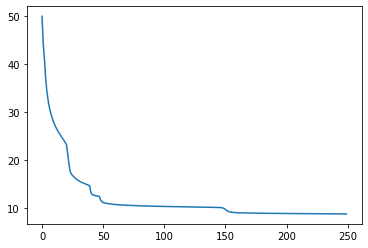

In [36]:
plt.plot(list(loss_dict.keys()), list(loss_dict.values()))
plt.show()

In [37]:
torch.save(model.state_dict(), 'crop_prediction_weights_final_best_trained.pth')

In [38]:
model.state_dict()

OrderedDict([('input.weight',
              tensor([[ 0.3404,  0.1901, -0.0578, -0.2643, -0.2768,  0.0169,  0.0388,  0.2357],
                      [ 0.1347,  0.2948, -0.3193, -0.1689,  0.1443,  0.3682,  0.4275, -0.2829],
                      [ 0.2704, -0.4523,  0.0994,  0.1274,  0.5328,  0.1060, -0.3626, -0.0180],
                      [ 0.3134, -0.2717, -0.0144,  0.4164, -0.0395, -0.0031, -0.2717, -0.2886],
                      [-0.2924,  0.0481,  0.1436,  0.3414,  0.1725,  0.5080,  0.3470,  0.4032],
                      [-0.1258, -0.1319,  0.3874, -0.2225, -0.2533, -0.2674, -0.4112, -0.3357],
                      [ 0.2865,  0.3494, -0.0064,  0.1623, -0.2691,  0.2427,  0.4432, -0.4812],
                      [ 0.1907, -0.0162,  0.0058, -0.0231, -0.2883, -0.0731, -0.1720, -0.1836],
                      [ 0.3598,  0.0365,  0.3593, -0.0399,  0.4266, -0.0385,  0.1772,  0.5515],
                      [-0.0342, -0.3048, -0.1325, -0.1461,  0.0543, -0.1569,  0.0463,  0.1447],
          

In [39]:
model2 = Model()
model2.load_state_dict(torch.load('crop_prediction_weights_final_best_trained.pth'))
model2.state_dict()

OrderedDict([('input.weight',
              tensor([[ 0.3404,  0.1901, -0.0578, -0.2643, -0.2768,  0.0169,  0.0388,  0.2357],
                      [ 0.1347,  0.2948, -0.3193, -0.1689,  0.1443,  0.3682,  0.4275, -0.2829],
                      [ 0.2704, -0.4523,  0.0994,  0.1274,  0.5328,  0.1060, -0.3626, -0.0180],
                      [ 0.3134, -0.2717, -0.0144,  0.4164, -0.0395, -0.0031, -0.2717, -0.2886],
                      [-0.2924,  0.0481,  0.1436,  0.3414,  0.1725,  0.5080,  0.3470,  0.4032],
                      [-0.1258, -0.1319,  0.3874, -0.2225, -0.2533, -0.2674, -0.4112, -0.3357],
                      [ 0.2865,  0.3494, -0.0064,  0.1623, -0.2691,  0.2427,  0.4432, -0.4812],
                      [ 0.1907, -0.0162,  0.0058, -0.0231, -0.2883, -0.0731, -0.1720, -0.1836],
                      [ 0.3598,  0.0365,  0.3593, -0.0399,  0.4266, -0.0385,  0.1772,  0.5515],
                      [-0.0342, -0.3048, -0.1325, -0.1461,  0.0543, -0.1569,  0.0463,  0.1447],
          

In [40]:
total = 0
correct = 0

for val in val_loader:
  valid_ip, valid_op = val
  pred_valid = model2(valid_ip)
  for pred, origi in zip(pred_valid.detach().numpy(), valid_op.detach().numpy()):
    i = np.argmax(pred)
    j = np.argmax(origi)
    total+=1
    if (i==j):
      correct+=1
print("Accuracy = ", correct*100/total)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy =  84.89340439706862


In [41]:
crops = ['arhar', 'bajra', 'barley', 'coriander', 'cotton', 'cowpea', 'dry chillies', 'garlic', 'ginger', 'gram', 'groundnut', 'jowar', 'linseed', 'maize-k', 'maize-r', 'masoor', 'moong', 'onion', 'peas&beans', 'potato', 'ragi', 'rapeseed', 'rice', 'safflower', 'sugarcane', 'sunflower', 'turmeric', 'urad', 'wheat']


pred_user = model2(torch.from_numpy(np.array([[17, 6.5, 40, 20, 17, 75, 25, 25]], dtype='float32')))
print(pred_user)

greater_than_zero={}
index = -1
count = 0
for i in pred_user:
    for p in i:
        index+=1
        if(p > 0):
            greater_than_zero[crops[index]] = p 
    for i in greater_than_zero:
        print("Crop:- {0}  Probab:- {1}".format(i,greater_than_zero[i]*100))

tensor([[2.4613e-11, 7.3618e-07, 6.0691e-10, 1.8440e-08, 3.0192e-13, 3.0173e-14,
         2.4937e-20, 3.5036e-10, 1.5884e-17, 8.6209e-16, 3.0756e-16, 3.6355e-07,
         5.4691e-12, 1.4335e-10, 1.3859e-03, 9.4492e-20, 6.0366e-29, 2.6463e-05,
         2.1942e-16, 9.9616e-01, 3.3612e-07, 1.3281e-26, 2.3006e-03, 1.0969e-17,
         2.1042e-06, 9.0081e-16, 7.0373e-09, 1.4764e-19, 1.2164e-04]],
       grad_fn=<SoftmaxBackward>)
Crop:- arhar  Probab:- 2.4613475702039977e-09
Crop:- bajra  Probab:- 7.361821917584166e-05
Crop:- barley  Probab:- 6.069130620289798e-08
Crop:- coriander  Probab:- 1.8440263147567748e-06
Crop:- cotton  Probab:- 3.019167901796571e-11
Crop:- cowpea  Probab:- 3.017278050673755e-12
Crop:- dry chillies  Probab:- 2.493667685053651e-18
Crop:- garlic  Probab:- 3.503550871641892e-08
Crop:- ginger  Probab:- 1.588397052030969e-15
Crop:- gram  Probab:- 8.620898726873286e-14
Crop:- groundnut  Probab:- 3.075623726512232e-14
Crop:- jowar  Probab:- 3.635514076449908e-05
Crop:- lin

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
